<a href="https://colab.research.google.com/github/IsaacFigNewton/Smishing-Detector/blob/sklearn-approach/Smishing_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

<ol>
  <li>Reimplement the TF-IDF scoring system; Score = (token TF-IDF scores from spam) - (token TF-IDF scores from ham).</li>
  <li>Use regexes to parse, score, then replace emails, phone numbers, and URLs with a dummy string for later NLP.</li>
  <li>Undersample ham messages in dataset or penalize supervised models for false negatives more heavily.</li>
  <li>Handle common symbol replacements and letter substitutions.</li>
  <li>Use stemming and lemmatization to reduce the TFIDF token vector space.</li>
</ol>

# Import and config

In [2]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [61]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk as nlp

from sklearn.pipeline import make_pipeline
from sklearn.metrics import *
from sklearn.metrics.pairwise import cosine_similarity,\
                                     cosine_distances

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans,\
                            SpectralClustering

In [ ]:
# Use BERT as the sentence encoder since it's the best open-source option
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
class_map = {"ham": 0, "spam": 1}
color_map = {0: "red", 0: "blue"}

char_ngrams = (1, 6)
word_ngrams = (1, 5)
minSusLen = 500
lenWeight = 0.01

In [5]:
np.random.seed(10)
random_state = 0

In [ ]:
# Load a pretrained Sentence Transformer model
sentence_embedder = SentenceTransformer("all-MiniLM-L6-v2")

# # create the vectorizer
# vec = TfidfVectorizer(ngram_range=word_ngrams, strip_accents="ascii") #, min_df=0.01, max_df=0.99)

#Import and clean data

## Important Functions

In [30]:
def prune_tokens(dict, minFreq, maxLen):
    tokensToRemove = []

    for key in dict.keys():
        if (dict[key] <= minFreq or maxLen <= (len(key) and " " not in key)):
            # add it to a list of tokens to prune
            tokensToRemove.append(key)

    for token in tokensToRemove:
        del dict[token]

    return dict

## Import, Clean data

In [115]:
# nltk.download()
corpus = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Smishing-Detector/sklearn-approach/dataset/SMSSpamCollection.txt", sep="\t", on_bad_lines='warn')

# clean the corpus
corpus = corpus.dropna(axis=0)

# clean and prepare the dataset
corpus.columns = ["class", "text"]
classifications = corpus["class"]
corpus_counts = corpus["class"].value_counts()
corpus["class"] = classifications.map(class_map)
# corpus = corpus.loc[:1000]

In [84]:
# # fit the vectorizer
# vec.fit(corpus["text"])

# # vectorize the corpus
# corpus_vectorization = vec.transform(corpus["text"])

# calculate embeddings by calling model.encode()
# corpus_vectorization = sentence_embedder.encode(corpus["text"])

# Data Exploration

<Axes: xlabel='class'>

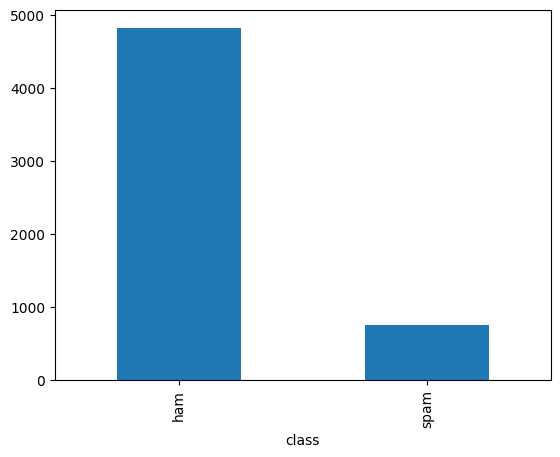

In [124]:
corpus_counts.plot.bar()

# Classification

## Models

### Unsupervised

In [85]:
# takes in a pd.Series, pd.DataFrame and returns an np.array
km_pipeline = make_pipeline(
    KMeans(n_clusters=2, random_state=random_state)
)

In [86]:
# takes in a pd.Series, pd.DataFrame and returns an np.array
spectral_pipeline = make_pipeline(
    SpectralClustering(n_clusters=2, random_state=random_state)
)

### Supervised

In [104]:
# takes in a pd.Series, pd.DataFrame and returns an np.array
knn_pipeline = make_pipeline(
    KNeighborsClassifier(n_neighbors=5)
)

In [88]:
# takes in a pd.Series, pd.DataFrame and returns an np.array
nb_pipeline = make_pipeline(
    GaussianNB()
)

## Important Functions

In [89]:
def unsupervised_predictions(corpus_vects, corpus_classes):
    # print(corpus_vects.shape[0])

    # get predictions
    km_predictions = pd.Series(data = km_pipeline.fit_predict(corpus_vects))\
                          .astype(int)
    spectral_predictions = pd.Series(data = spectral_pipeline.fit_predict(corpus_vects))\
                          .astype(int)

    # combine into 1 dataframe and cast to correct type
    predictions = pd.DataFrame({
        "K-Means Clustering": km_predictions,
        "Spectral Clustering": spectral_predictions
    })

    # print(predictions.head())

    return predictions

In [90]:
def supervised_predictions(training_vects, training_classes, testing_vects, testing_classes):
    # print(training_vects.shape[0])

    # get predictions
    knn_pipeline.fit(training_vects, training_classes)
    knn_predictions = pd.Series(data = knn_pipeline.predict(testing_vects))\
                          .astype(int)
    nb_pipeline.fit(training_vects, training_classes)
    nb_predictions = pd.Series(data = knn_pipeline.predict(testing_vects))\
                          .astype(int)

    # combine into 1 dataframe and cast to correct type
    predictions = pd.DataFrame({
        "K Nearest Neighbor": knn_predictions,
        "Naive Bayes": nb_predictions
    })

    # print(predictions.head())

    return predictions

In [91]:
def get_spam_scores(training_vects, training_classes, testing_vects, testing_classes):
    bias = 0.1

    # #get a mask of the sms's longer than minSusLen
    # text_len_mask = test["text"].apply(len).ge(minSusLen)
    # #add the excess length * the weight to the total score
    # scores[text_len_mask] = scores[text_len_mask].add((test["text"]).multiply(lenWeight))

    # # vectorize the training and test data using the same vectorizer as for creating corpus_vectorization
    # training_vects = vec.transform(train["text"])
    # training_classes = train["class"]
    # testing_vects = vec.transform(test["text"])
    # testing_classes = test["class"]

    # baseline = pd.DataFrame(data=[np.zeros((len(testing_classes.shape[2]), 2))], columns=["baseline"])

    # get mean of unsupervised models' predictions
    unsupervised = unsupervised_predictions(testing_vects, testing_classes)  #.mean(axis=1)

    # get mean of unsupervised models' predictions
    supervised = supervised_predictions(training_vects, training_classes, testing_vects, testing_classes)  #.mean(axis=1)

    # get scores for all models
    scores = pd.concat([unsupervised, supervised], axis=1, ignore_index=True).dropna()
    # scores = pd.concat([scores, baseline], axis=1, ignore_index=True).dropna()
    scores = scores.add(bias)

    # rename the columns
    scores.columns = list(unsupervised.columns) + list(supervised.columns)  # + ["baseline"]

    scores[scores > 0.5] = 1
    scores[scores < 0.5] = 0
    return scores.astype(int)

## Do stuff

In [92]:
# get training, test data
train, test = train_test_split(corpus, test_size=0.2)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train_vects = sentence_embedder.encode(train["text"])
test_vects = sentence_embedder.encode(test["text"])

In [105]:
# get unsupervised classifier predictions
predictions = get_spam_scores(train_vects, train["class"], test_vects, test["class"])
predictions.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,K-Means Clustering,Spectral Clustering,K Nearest Neighbor,Naive Bayes
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,1,1,0,0


In [106]:
actual = pd.DataFrame(data=corpus["class"])
actual.columns = ["actual"]
actual.head()

,actual
0,0
1,1
2,0
3,0
4,1


In [107]:
expected_and_predictions = pd.concat([actual, predictions], axis=1, ignore_index=True).dropna()
expected_and_predictions.columns = ["actual"] + list(predictions.columns)
expected_and_predictions

,actual,K-Means Clustering,Spectral Clustering,K Nearest Neighbor,Naive Bayes
0,0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0
4,1,1.0,1.0,0.0,0.0
...,...,...,...,...,...
1110,0,1.0,1.0,0.0,0.0
1111,0,0.0,0.0,0.0,0.0
1112,0,0.0,0.0,0.0,0.0
1113,0,0.0,0.0,0.0,0.0


# Model Comparison

In [108]:
def format(stat):
    return "\t" + str('%.3f'%stat)

K Nearest Neighbor scores:
Mean Squared Error		0.259
Mean Absolute Error		0.259
False Positive Rate		0.867
False Negative Rate		0.154
Accuracy			0.741
Precision			0.133
Recall				0.131
F1				0.132


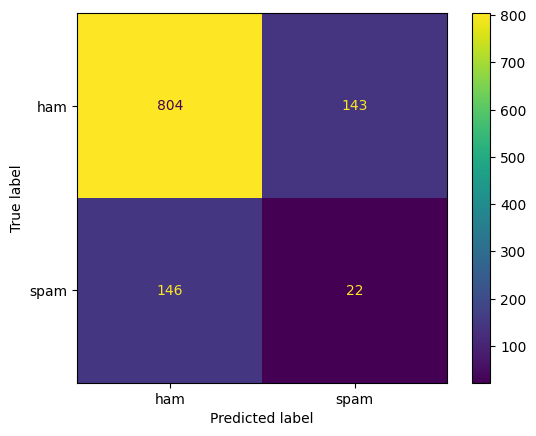


K-Means Clustering scores:
Mean Squared Error		0.363
Mean Absolute Error		0.363
False Positive Rate		0.867
False Negative Rate		0.132
Accuracy			0.637
Precision			0.133
Recall				0.256
F1				0.175


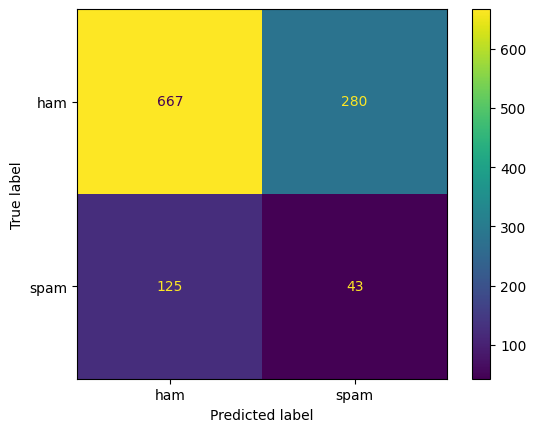


Naive Bayes scores:
Mean Squared Error		0.259
Mean Absolute Error		0.259
False Positive Rate		0.867
False Negative Rate		0.154
Accuracy			0.741
Precision			0.133
Recall				0.131
F1				0.132


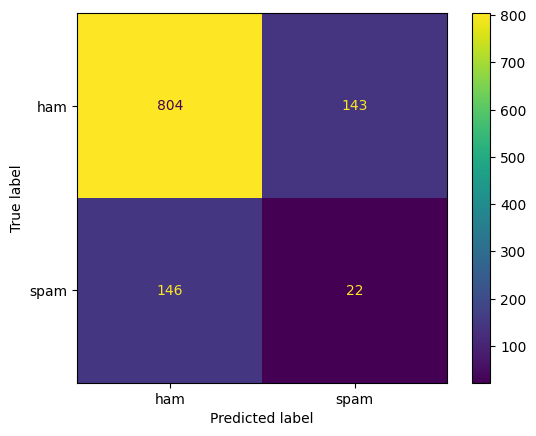


Spectral Clustering scores:
Mean Squared Error		0.320
Mean Absolute Error		0.320
False Positive Rate		0.865
False Negative Rate		0.140
Accuracy			0.680
Precision			0.135
Recall				0.208
F1				0.164


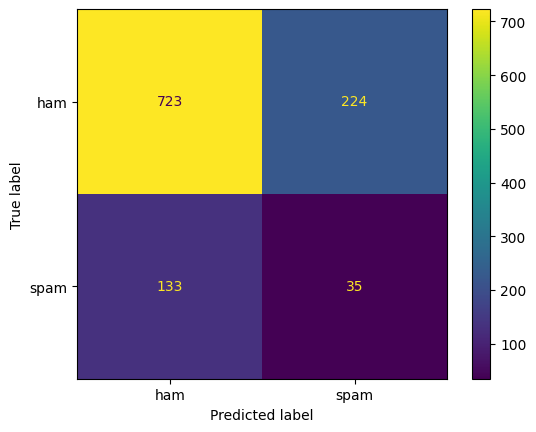

In [113]:
# get scoring metrics
scores = {}
scores_df = pd.DataFrame()

for model_name in sorted(list(set(expected_and_predictions.columns) - {"actual"})):

    confusion = confusion_matrix(expected_and_predictions["actual"], expected_and_predictions[model_name])

    scores[model_name] = {
        "Mean Squared Error\t": mean_squared_error(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Mean Absolute Error\t":  mean_absolute_error(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "False Positive Rate\t": confusion[0][1]/confusion.sum(axis=0)[1],
        "False Negative Rate\t": confusion[1][0]/confusion.sum(axis=1)[0],
        "Accuracy\t\t": accuracy_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Precision\t\t": precision_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "Recall\t\t\t":  recall_score(expected_and_predictions["actual"], expected_and_predictions[model_name]),
        "F1\t\t\t":  f1_score(expected_and_predictions["actual"], expected_and_predictions[model_name])
    }

    print(model_name + " scores:")

    for metric, value in scores[model_name].items():
        print(metric + format(value))

    confusion_display = ConfusionMatrixDisplay(confusion, display_labels=["ham", "spam"])
    confusion_display.plot()
    plt.show()

    print()

In [110]:
# # print(corpus.head())
# sms = "free money click here"
# print(sms)
#
# prediction = get_spam_score(pd.Series(data=[sms]), corpus)[0]
# if 0 < prediction:
#     print("The sms is spam")
# else:
#     print("The sms is ham")